In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
import xgboost as xgb
import seaborn as sns

warnings.filterwarnings("ignore")
random_seed = 8

In [2]:
# collected form each main diabetic indicator features regressors
cols = np.unique(
    [
        "AGE","FIELD_31","FIELD_33","FIELD_38","FIELD_40","L100500","L100700","L100800","L101200","L101300",
        "L101600","L101700","L103000","L103100","L103300","L104600","L107400","L190000","L190300","L190400",
        "S000100","S000300","S000501","S000502","SEX","FIELD_1","FIELD_2","FIELD_16","FIELD_23","FIELD_15",
        "FIELD_22","FIELD_17","FIELD_24",'CLASS'
    ]
)

In [3]:
xcols=[]
ycols=[]
allxycols=[]

for i in cols:
    xcols.append (i+'_x')
    ycols.append (i+'_y')
    
    allxycols.append (i+'_x')
    allxycols.append (i+'_y')

Read Dataset
====

In [4]:
x_original = pd.read_csv("../../XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original=x_original #[cols]

print(x_original.shape)

(185843, 409)


In [5]:
x_original=x_original.drop(
x_original.query('L103000.isnull() or L104600.isnull() or S000300.isnull() or L101700.isnull() or L100700.isnull() or FIELD_33.isnull() or FIELD_38.isnull() or FIELD_40.isnull() or FIELD_31.isnull() or SEX.isnull() or AGE.isnull() '
                 , engine='python')[['L103000','L104600','S000300','L101700','L100700']].index)

In [6]:
y_original = pd.read_csv("../../TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original=y_original #[cols]

In [7]:
y_original=y_original.drop(
y_original.query('L103000.isnull() or L104600.isnull() or S000300.isnull() or L101700.isnull() or L100700.isnull() or FIELD_33.isnull() or FIELD_38.isnull() or FIELD_40.isnull() or FIELD_31.isnull() or SEX.isnull() or AGE.isnull() '
                 , engine='python')[['L103000','L104600','S000300','L101700','L100700']].index)

In [8]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

Prepare dataset
===

In [9]:
# filter the data set
data = data[data.FIELD_16_x != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23_x != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15_x != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22_x != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17_x != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24_x != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[allxycols]#.dropna()
print(data.shape)

(47717, 68)


In [10]:
x = data[xcols]
y = data[ycols]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

Train Regression Models
==========

L104600_y # HBA1C
====

In [11]:
# regr = RandomForestRegressor(
#     max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=4
# )

# regr.fit(
#     xtrain[
#         [
#             "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x","L101700_x","S000502_x",
#             "L190000_x","L101600_x","L190300_x",
#         ]
#     ],
#     ytrain[["L104600_y"]],
# )

# ypred = regr.predict(
#     xtest[
#         [
#            "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x","L101700_x","S000502_x",
#             "L190000_x","L101600_x","L190300_x",
#         ]
#     ]
# )

# print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))


regr = xgb.XGBRegressor(colsample_bytree=0.6,objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.02,
                 max_depth=12,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.4,
                 seed=42) 

regr.fit(xtrain,  ytrain[["L104600_y"]])

ypred = regr.predict(xtest)

print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))


r2_score 0.6712433781540454


In [12]:
pred_L104600 = ypred
pred_L104600.shape

(9544,)

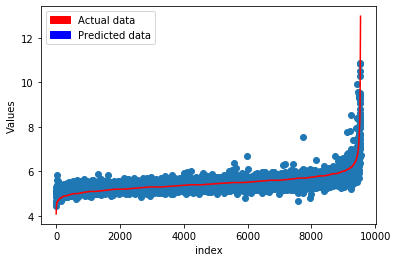

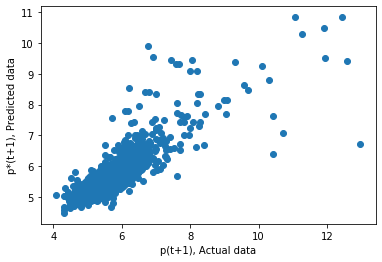

In [13]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L104600_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

L103000 #Triglyceride
=====

In [14]:
# regr = RandomForestRegressor(
#     max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
# )
# regr.fit(
#     xtrain[
#         [
#             "L103000_x",
#             "L100700_x",
#             "L101700_x",
#             "S000300_x",
#             "S000502_x",
#             "FIELD_33_x",
#             "L190000_x",
#             "L100800_x",
#             "L101600_x",
#             "S000501_x",
#         ]
#     ],
#     ytrain[["L103000_y"]],
# )

# ypred = regr.predict(
#     xtest[
#         [
#             "L103000_x",
#             "L100700_x",
#             "L101700_x",
#             "S000300_x",
#             "S000502_x",
#             "FIELD_33_x",
#             "L190000_x",
#             "L100800_x",
#             "L101600_x",
#             "S000501_x",
#         ]
#     ]
# )

# print("r2_score", m.r2_score(ytest[["L103000_y"]], ypred))

regr = xgb.XGBRegressor(colsample_bytree=0.4,objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

regr.fit(xtrain,  ytrain[["L103000_y"]])

ypred = regr.predict(xtest)

print("r2_score", m.r2_score(ytest[["L103000_y"]], ypred))


r2_score 0.5103274166478793


In [15]:
pred_L103000 = ypred

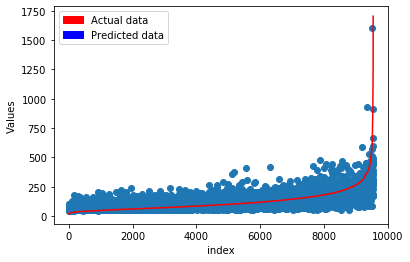

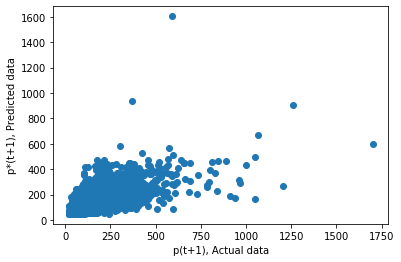

In [16]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L103000_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

S000300 #BMI
===

In [17]:
# regr = RandomForestRegressor(
#     max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
# )
# regr.fit(
#     xtrain[
#         [
#             "S000300_x",
#             "L103300_x",
#             "S000501_x",
#             "L100700_x",
#             "SEX_x",
#             "L103100_x",
#             "L190300_x",
#             "L190400_x",
#             "L101300_x",
#             "S000502_x",
#         ]
#     ],
#     ytrain[["S000300_y"]],
# )

# ypred = regr.predict(
#     xtest[
#         [
#             "S000300_x",
#             "L103300_x",
#             "S000501_x",
#             "L100700_x",
#             "SEX_x",
#             "L103100_x",
#             "L190300_x",
#             "L190400_x",
#             "L101300_x",
#             "S000502_x",
#         ]
#     ]
# )

# print("r2_score", m.r2_score(ytest[["S000300_y"]], ypred))


regr = xgb.XGBRegressor(colsample_bytree=0.4,objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=12,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

regr.fit(xtrain,  ytrain[["S000300_y"]])

ypred = regr.predict(xtest)

print("r2_score", m.r2_score(ytest[["S000300_y"]], ypred))




r2_score 0.8904651206116022


In [18]:
pred_S000300 = ypred

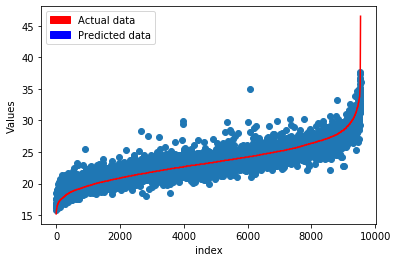

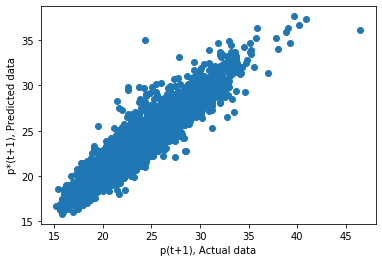

In [19]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["S000300_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

L101700 # r-GTP gamma
===

In [20]:
# regr = RandomForestRegressor(
#     max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
# )
# regr.fit(
#     xtrain[
#         [
#             "L101700_x",
#             "L101300_x",
#             "L103000_x",
#             "SEX_x",
#             "L100700_x",
#             "L101200_x",
#             "S000300_x",
#             "S000501_x",
#             "L100800_x",
#             "S000502_x",
#             "L101600_x",
#             "S000100_x",
#         ]
#     ],
#     ytrain[["L101700_y"]],
# )

# ypred = regr.predict(
#     xtest[
#         [
#             "L101700_x",
#             "L101300_x",
#             "L103000_x",
#             "SEX_x",
#             "L100700_x",
#             "L101200_x",
#             "S000300_x",
#             "S000501_x",
#             "L100800_x",
#             "S000502_x",
#             "L101600_x",
#             "S000100_x",
#         ]
#     ]
# )

# print("r2_score", m.r2_score(ytest[["L101700_y"]], ypred))




regr = xgb.XGBRegressor(colsample_bytree=0.4,objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.02,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

regr.fit(xtrain,  ytrain[["L101700_y"]])

ypred = regr.predict(xtest)

print("r2_score", m.r2_score(ytest[["L101700_y"]], ypred))





r2_score 0.7026657828222852


In [21]:
pred_L101700 = ypred

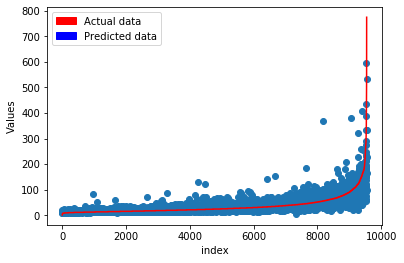

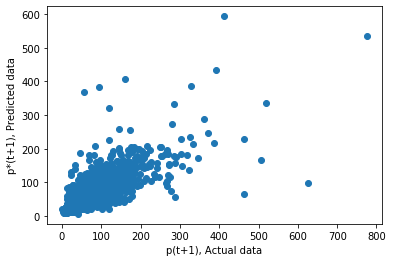

In [22]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L101700_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

L100700 #Uric acid
====

In [23]:
# regr = RandomForestRegressor(
#     max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
# )
# regr.fit(
#     xtrain[
#         [
#             "L100700_x",
#             "L100500_x",
#             "S000100_x",
#             "S000300_x",
#             "L103300_x",
#             "L103000_x",
#             "L103100_x",
#             "S000501_x",
#             "L101300_x",
#             "L101700_x",
#             "S000502_x",
#             "L107400_x",
#         ]
#     ],
#     ytrain[["L100700_y"]],
# )

# ypred = regr.predict(
#     xtest[
#         [
#             "L100700_x",
#             "L100500_x",
#             "S000100_x",
#             "S000300_x",
#             "L103300_x",
#             "L103000_x",
#             "L103100_x",
#             "S000501_x",
#             "L101300_x",
#             "L101700_x",
#             "S000502_x",
#             "L107400_x",
#         ]
#     ]
# )

# print("r2_score", m.r2_score(ytest[["L100700_y"]], ypred))


regr = xgb.XGBRegressor(colsample_bytree=0.4,objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

regr.fit(xtrain,  ytrain[["L100700_y"]])

ypred = regr.predict(xtest)

print("r2_score", m.r2_score(ytest[["L100700_y"]], ypred))



r2_score 0.7588161876113864


In [24]:
pred_L100700 = ypred

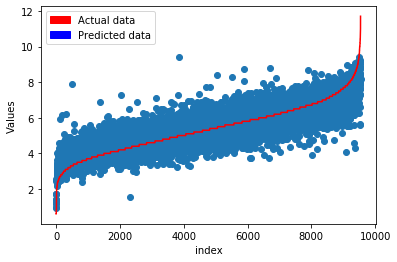

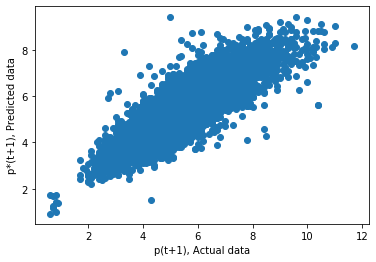

In [25]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L100700_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

Categorical values
=====

In [26]:
pred_FIELD_33 = ytest.FIELD_33_y

In [27]:
pred_FIELD_38 = ytest.FIELD_38_y

In [28]:
pred_FIELD_40 = ytest.FIELD_40_y

In [29]:
pred_FIELD_31 = ytest.FIELD_31_y

In [30]:
pred_SEX = ytest.SEX_y

In [31]:
pred_AGE = ytest.AGE_y + 1

Combine the predicted values to make dataframe
====

In [32]:
NextYearData = pd.DataFrame()
NextYearData["P_FIELD_1"] = ytest.FIELD_1_y.values
NextYearData["P_FIELD_2"] = ytest.FIELD_2_y.values
NextYearData["P_L104600"] = pred_L104600
NextYearData["P_L103000"] = pred_L103000
NextYearData["P_S000300"] = pred_S000300
NextYearData["P_L101700"] = pred_L101700
NextYearData["P_L100700"] = pred_L100700
NextYearData["P_FIELD_33"] = pred_FIELD_33.values
NextYearData["P_FIELD_38"] = pred_FIELD_38.values
NextYearData["P_FIELD_40"] = pred_FIELD_40.values
NextYearData["P_FIELD_31"] = pred_FIELD_31.values
NextYearData["P_SEX"] = pred_SEX.values
NextYearData["P_AGE"] = pred_AGE.values

NextYearData["P_AGE"] = pred_AGE.values
NextYearData["P_AGE"] = pred_AGE.values


NextYearData["A_L100800"] = ytest.L100800_y.values

conditions = [
    (NextYearData.A_L100800 < 100),
    (NextYearData.A_L100800 >= 100) & (NextYearData.A_L100800 < 126),
    (NextYearData.A_L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData["A_CLASS"] = np.select(conditions, choices, default=0)
NextYearData.head()

,P_FIELD_1,P_FIELD_2,P_L104600,P_L103000,P_S000300,P_L101700,P_L100700,P_FIELD_33,P_FIELD_38,P_FIELD_40,P_FIELD_31,P_SEX,P_AGE,A_L100800,A_CLASS
0,913749,20140703,5.383505,82.553322,20.106125,23.030743,4.407765,2.0,0.0,2.0,0.0,0.0,45.0,98.0,0
1,351151,20161017,5.553661,150.190628,24.407711,120.418961,5.944971,3.0,2.0,0.0,0.0,0.0,33.0,101.0,1
2,3786597,20171017,5.597504,76.386597,31.218405,21.297911,4.467354,1.0,0.0,6.0,0.0,1.0,53.0,81.0,0
3,667213,20161010,5.468863,129.614944,25.741705,33.621571,5.529395,3.0,2.0,5.0,0.0,0.0,40.0,98.0,0
4,4467101,20171226,5.671575,149.006348,28.564774,44.318199,7.169037,2.0,3.0,2.0,0.0,0.0,32.0,93.0,0


In [33]:
NextYearData.to_csv("Predicted_NextYearData.txt", sep=",")

==============================================
==========

In [34]:
# select the actual next year values

NextYearData_actualData = pd.DataFrame()
NextYearData_actualData["FIELD_1"] = ytest.FIELD_1_y.values
NextYearData_actualData["FIELD_2"] = ytest.FIELD_2_y.values
NextYearData_actualData["L104600"] = ytest.L104600_y.values
NextYearData_actualData["L103000"] = ytest.L103000_y.values
NextYearData_actualData["S000300"] = ytest.S000300_y.values
NextYearData_actualData["L101700"] = ytest.L101700_y.values
NextYearData_actualData["L100700"] = ytest.L100700_y.values
NextYearData_actualData["FIELD_33"] = ytest.FIELD_33_y.values
NextYearData_actualData["FIELD_38"] = ytest.FIELD_38_y.values
NextYearData_actualData["FIELD_40"] = ytest.FIELD_40_y.values
NextYearData_actualData["FIELD_31"] = ytest.FIELD_31_y.values
NextYearData_actualData["SEX"] = ytest.SEX_y.values
NextYearData_actualData["AGE"] = ytest.AGE_y.values

NextYearData_actualData["L100800"] = ytest.L100800_y.values

conditions = [
    (NextYearData_actualData.L100800 < 100),
    (NextYearData_actualData.L100800 >= 100) & (NextYearData_actualData.L100800 < 126),
    (NextYearData_actualData.L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData_actualData["CLASS"] = np.select(conditions, choices, default=0)
NextYearData_actualData.head()

NextYearData_actualData.to_csv("NextYearData_actualData_test.txt", sep=",")

==========================================================
===

In [35]:
# select the actual this year values

ThisYearData_actualData = pd.DataFrame()
ThisYearData_actualData["FIELD_1"] = xtest.FIELD_1_x.values
ThisYearData_actualData["FIELD_2"] = xtest.FIELD_2_x.values
ThisYearData_actualData["L104600"] = xtest.L104600_x.values
ThisYearData_actualData["L103000"] = xtest.L103000_x.values
ThisYearData_actualData["S000300"] = xtest.S000300_x.values
ThisYearData_actualData["L101700"] = xtest.L101700_x.values
ThisYearData_actualData["L100700"] = xtest.L100700_x.values
ThisYearData_actualData["FIELD_33"] = xtest.FIELD_33_x.values
ThisYearData_actualData["FIELD_38"] = xtest.FIELD_38_x.values
ThisYearData_actualData["FIELD_40"] = xtest.FIELD_40_x.values
ThisYearData_actualData["FIELD_31"] = xtest.FIELD_31_x.values
ThisYearData_actualData["SEX"] = xtest.SEX_x.values
ThisYearData_actualData["AGE"] = xtest.AGE_x.values
ThisYearData_actualData["L100800"] = xtest.L100800_x.values

conditions = [
    (ThisYearData_actualData.L100800 < 100),
    (ThisYearData_actualData.L100800 >= 100) & (ThisYearData_actualData.L100800 < 126),
    (ThisYearData_actualData.L100800 >= 126),
]
choices = [0, 1, 2]
ThisYearData_actualData["CLASS"] = np.select(conditions, choices, default=0)
ThisYearData_actualData.head()

ThisYearData_actualData.to_csv("ThisYearData_actualData_test.txt", sep=",")

============================================
=========

In [36]:
# select the actual next year values train

NextYearData_actualData_train = pd.DataFrame()
NextYearData_actualData_train["FIELD_1"] = ytrain.FIELD_1_y.values
NextYearData_actualData_train["FIELD_2"] = ytrain.FIELD_2_y.values
NextYearData_actualData_train["L104600"] = ytrain.L104600_y.values
NextYearData_actualData_train["L103000"] = ytrain.L103000_y.values
NextYearData_actualData_train["S000300"] = ytrain.S000300_y.values
NextYearData_actualData_train["L101700"] = ytrain.L101700_y.values
NextYearData_actualData_train["L100700"] = ytrain.L100700_y.values
NextYearData_actualData_train["FIELD_33"] = ytrain.FIELD_33_y.values
NextYearData_actualData_train["FIELD_38"] = ytrain.FIELD_38_y.values
NextYearData_actualData_train["FIELD_40"] = ytrain.FIELD_40_y.values
NextYearData_actualData_train["FIELD_31"] = ytrain.FIELD_31_y.values
NextYearData_actualData_train["SEX"] = ytrain.SEX_y.values
NextYearData_actualData_train["AGE"] = ytrain.AGE_y.values

NextYearData_actualData_train["L100800"] = ytrain.L100800_y.values

conditions = [
    (NextYearData_actualData_train.L100800 < 100),
    (NextYearData_actualData_train.L100800 >= 100)
    & (NextYearData_actualData_train.L100800 < 126),
    (NextYearData_actualData_train.L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData_actualData_train["CLASS"] = np.select(conditions, choices, default=0)
NextYearData_actualData_train.head()

NextYearData_actualData_train.to_csv("NextYearData_actualData_train.txt", sep=",")

=================================================
==============

In [37]:
# select the actual this year values train

ThisYearData_actualData_train = pd.DataFrame()
ThisYearData_actualData_train["FIELD_1"] = xtrain.FIELD_1_x.values
ThisYearData_actualData_train["FIELD_2"] = xtrain.FIELD_2_x.values
ThisYearData_actualData_train["L104600"] = xtrain.L104600_x.values
ThisYearData_actualData_train["L103000"] = xtrain.L103000_x.values
ThisYearData_actualData_train["S000300"] = xtrain.S000300_x.values
ThisYearData_actualData_train["L101700"] = xtrain.L101700_x.values
ThisYearData_actualData_train["L100700"] = xtrain.L100700_x.values
ThisYearData_actualData_train["FIELD_33"] = xtrain.FIELD_33_x.values
ThisYearData_actualData_train["FIELD_38"] = xtrain.FIELD_38_x.values
ThisYearData_actualData_train["FIELD_40"] = xtrain.FIELD_40_x.values
ThisYearData_actualData_train["FIELD_31"] = xtrain.FIELD_31_x.values
ThisYearData_actualData_train["SEX"] = xtrain.SEX_x.values
ThisYearData_actualData_train["AGE"] = xtrain.AGE_x.values
ThisYearData_actualData_train["L100800"] = xtrain.L100800_x.values

conditions = [
    (ThisYearData_actualData_train.L100800 < 100),
    (ThisYearData_actualData_train.L100800 >= 100)
    & (ThisYearData_actualData_train.L100800 < 126),
    (ThisYearData_actualData_train.L100800 >= 126),
]
choices = [0, 1, 2]
ThisYearData_actualData_train["CLASS"] = np.select(conditions, choices, default=0)
ThisYearData_actualData_train.head()

ThisYearData_actualData_train.to_csv("ThisYearData_actualData_train.txt", sep=",")